In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load data from clustering to identify seeds that drove clustering early

In [2]:
import dill

with open('/data/norman/southark/tfs_standardized/20240309_RPE1_CRISPRa_masked_variables.pickle', 'rb') as file:
    data = dill.load(file)

rpe1_seq_cluster_info = data['seq_cluster_info']

with open('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_masked_variables.pickle', 'rb') as file:
    data = dill.load(file)

fibro_seq_cluster_info = data['seq_cluster_info']

rpe1_seq_cluster_info['cluster_frac'] = rpe1_seq_cluster_info.cluster_size / rpe1_seq_cluster_info.total_sgRNAs_with_seed
fibro_seq_cluster_info['cluster_frac'] = fibro_seq_cluster_info.cluster_size / fibro_seq_cluster_info.total_sgRNAs_with_seed


seq_thresholds = pd.DataFrame([rpe1_seq_cluster_info['threshold'], fibro_seq_cluster_info['threshold'],]).T
remove_rank = seq_thresholds.rank().mean(axis=1).sort_values().head(75)

#get list of bad seeds
bad_seeds = remove_rank.index.str.split('_').str[1]

In [3]:
baddest_seeds = remove_rank.head(50).index.map(lambda x: x.split('_')[1])

In [4]:
seq_thresholds.columns = ['Hs27 threshold', 'RPE1 threshold']

In [5]:
both_thresholds = seq_thresholds.dropna()

In [6]:
both_thresholds.index = both_thresholds.index.map(lambda x: x.split('_')[1])

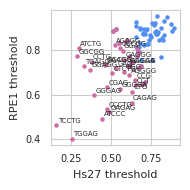

In [89]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(2, 2))

# Create the scatter plot for good seeds
good_seeds_data = both_thresholds.loc[~both_thresholds.index.isin(baddest_seeds)]
ax.scatter(good_seeds_data["Hs27 threshold"], good_seeds_data["RPE1 threshold"], color="#528FF0", label="Good seeds", s=5)

# Plot the bad seeds in a different color and annotate them
bad_seeds_data = both_thresholds.loc[both_thresholds.index.isin(bad_seeds)]
ax.scatter(bad_seeds_data["Hs27 threshold"], bad_seeds_data["RPE1 threshold"], color="#CE6DA1", label="Bad seeds", s=5)

baddest_seeds_data = both_thresholds.loc[both_thresholds.index.isin(baddest_seeds)]
for idx, row in baddest_seeds_data.iterrows():
    ax.annotate(idx, (row["Hs27 threshold"], row["RPE1 threshold"]), textcoords="offset points", xytext=(1, 1), ha='left', va='bottom', fontsize=5)

# Set the plot title and labels
ax.set_xlabel("Hs27 threshold", fontsize=8)
ax.set_ylabel("RPE1 threshold", fontsize=8)

# Add a grid
ax.grid(True)
ax.tick_params(axis='both', labelsize=7)

# Add a legend
#ax.legend(fontsize=10)

# Adjust the layout and display the plot
fig.tight_layout()
plt.savefig('20240405_bad_seeds.pdf', bbox_inches='tight')
plt.show()

# Looking for forward or reverse PAM sequences in bad seeds

In [72]:
seeds = ['TCCTG', 'CTGGAG', 'TGGAG', 'CGGCGG', 'ACAGAG', 'ATCCC', 'CCCCT',
       'GGGAG', 'AAGGGG', 'GGGGAG', 'GAGAG', 'CCCTG', 'CGAG', 'GGAGG',
       'TGTCCG', 'TGAGG', 'GGGGA', 'CTCTG', 'CGGGGA', 'AGACC', 'GAGGTG',
       'GAAGG', 'CCTG', 'AGCGG', 'GAG', 'GGCGG', 'GGAG', 'ACCTG', 'CAGAG',
       'GGG', 'TGGGG', 'ATCTG', 'TCCCG', 'CGGAAG', 'CTG', 'AGGGG', 'GACGG',
       'CCT', 'CACTG', 'CCG', 'GGGAA', 'ATGAG', 'GAGGG', 'AAGGG', 'CGGAG',
       'AGAGG', 'TGGGT', 'CCCGG', 'GGA', 'AGGTG', 'CGAGG', 'AAGAG', 'AGGGT',
       'GAGG', 'TCCG', 'GGAGA', 'GTCCG', 'TGGG', 'CCAGG', 'GAGGGG', 'GTG',
       'TAGAG', 'GGAAG', 'GAGTG', 'TGAG', 'CGGGG', 'GGGG', 'GGGTG', 'ACTG',
       'ACCCGG', 'AGGAG', 'CGGGA', 'CCC', 'GGGGG', 'CTGGA'] # from Kaden

In [73]:
seeds = [seed for seed in seeds if len(seed) <= 6]

In [74]:
def count_pam_sequences(seed):
    pam_count = 0
    for i in range(len(seed) - 1):
        if seed[i:i+2] in ['GG', 'AG']:
            pam_count += 1
    return pam_count

def count_reverse_pam_sequences(seed):
    pam_count = 0
    for i in range(len(seed) - 1):
        if seed[i:i+2] in ['CC', 'CT']:
            pam_count += 1
    return pam_count

In [75]:
pam_counts = pd.Series({seed: count_pam_sequences(seed) for seed in seeds})
reverse_pam_counts = pd.Series({seed: count_reverse_pam_sequences(seed) for seed in seeds})

In [76]:
forward_seeds = list(pam_counts[pam_counts >= reverse_pam_counts].index.values)
reverse_seeds = list(reverse_pam_counts[pam_counts < reverse_pam_counts].index.values)

In [77]:
# Find the maximal length among all strings in forward_seeds and reverse_seeds
max_length = max(len(seed) for seed in forward_seeds + reverse_seeds)

# Pad the shorter strings in forward_seeds with 'N' characters on the left
forward_seeds = ['N' * (max_length - len(seed)) + seed for seed in forward_seeds]

# Pad the shorter strings in reverse_seeds with 'N' characters on the left
reverse_seeds = ['N' * (max_length - len(seed)) + seed for seed in reverse_seeds]

seeds = ['N' * (max_length - len(seed)) + seed for seed in seeds]

In [86]:
import logomaker
import matplotlib.pyplot as plt

def create_sequence_logo(seeds, title, width=2, height=1.3, filename=None):
    counts_matrix = logomaker.alignment_to_matrix(seeds)
    logo = logomaker.Logo(counts_matrix, color_scheme='classic', figsize=(width, height))
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    
    # Set the x-labels to count down from 20
    num_positions = counts_matrix.shape[1] + 1
    x_labels = list(range(21 - num_positions, 21, 1))
    logo.style_xticks(rotation=90, fontsize=7)
    logo.ax.set_xticks(range(num_positions))
    logo.ax.set_xticklabels(x_labels)
    logo.ax.tick_params(axis='both', labelsize=7)
    
    logo.ax.set_ylabel('Frequency', fontsize=8)
    #logo.ax.set_title(title, fontsize=12)
    logo.fig.tight_layout()

    if filename:
        # Save the logo to a PDF file
        logo.fig.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

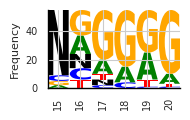

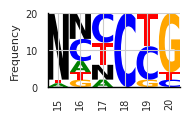

In [87]:
create_sequence_logo(forward_seeds, 'Forward PAM seeds', filename='20240405_forward_seed_sequence_logo.pdf')
create_sequence_logo(reverse_seeds, 'Reverse PAM seeds', filename='20240405_reverse_seed_sequence_logo.pdf')
#create_sequence_logo(seeds, 'Sequence Logo for all seeds')

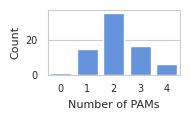

In [88]:
total_pam_counts = (pam_counts + reverse_pam_counts).value_counts().sort_index()

# Set the style and color
sns.set_style("whitegrid")
color = "#528FF0"

# Create a figure and axis
fig, ax = plt.subplots(figsize=(2, 1.3))

# Create the bar plot with no space between bars and a single color
sns.barplot(x=total_pam_counts.index, y=total_pam_counts.values, ax=ax, color=color)

# Set the plot title and labels
ax.set_xlabel("Number of PAMs", fontsize=8)
ax.set_ylabel("Count", fontsize=8)
plt.tick_params(axis='both', labelsize=7)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(total_pam_counts.index, ha='center')


# Adjust the layout and display the plot
fig.tight_layout()
plt.savefig('20240405_number_of_PAMs.pdf', bbox_inches='tight')

plt.show()

# Showing that seeds can drive phenotypes

In [7]:
mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Loading metadata...
Done in 2.657951593399048s.
Done.


In [8]:
mean_pop.genes.index.name = 'gene_id'

In [9]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [11]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

In [12]:
guide_library['masked_active'] = mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)

In [14]:
guide_library['de_genes'] = mean_pop.cells['de_genes']

In [143]:
sns.set_style('white')

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


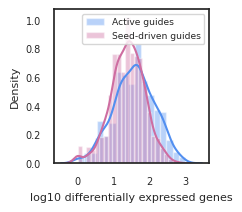

In [144]:
# Set the size of the figure
plt.figure(figsize=(2, 2))  # 2x2 inches times the scaling factor (4)

# Plot the data
sns.distplot(np.log10(1+guide_library.query('masked_active')['de_genes']), color="#528FF0", label='Active guides')
sns.distplot(np.log10(1+guide_library.query('seed_driven_fibro')['de_genes']), color='#CE6DA1', label='Seed-driven guides')

# Add legend
plt.legend()

# Adjust axes labels size
plt.xlabel('log10 differentially expressed genes', fontsize=8)
plt.ylabel('Density', fontsize=8)

# Adjust tick labels size
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# Display the plot
plt.savefig('20240409_seeds_vs_active_guides_de_genes.pdf', bbox_inches='tight')

In [127]:
comps = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_comps.csv', index_col=0)

total_codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_total_fibroblast_bulk_codes.csv', index_col=0)
total_codes.columns = total_codes.columns.astype(int)

In [128]:
df = pd.DataFrame([mean_pop.cells['cluster_description'], mean_pop.cells['sequence_driven'], total_codes[4]], index=['cluster', 'sequence_driven', 'EMT_score']).T

In [129]:
df['sequence_driven'].fillna(False, inplace=True)

In [130]:
df['EMT_score'] = df['EMT_score'].astype(float)

In [131]:
mean_df = df.query('sequence_driven').groupby('cluster').median()
mean_df['size'] = mean_pop.cells.groupby('cluster_description').size()

In [132]:
mean_df.query('size > 5').sort_values('EMT_score')

,sequence_driven,EMT_score,size
cluster,,,
1548: SEQUENCE-driven (GGGGA) (14),1.0000,-2.1929,14
2097: SEQUENCE-driven (AGAGG) (17),1.0000,-2.1291,17
443: SEQUENCE-driven (CCT) (6),1.0000,-1.7158,6
1533: SEQUENCE-driven (GGGAG) (19),1.0000,-1.6714,19
1486: SEQUENCE-driven (GAGAG) (8),1.0000,-1.5490,8
...,...,...,...
1658: SEQUENCE-driven (CAC) (8),1.0000,0.7297,8
1428: SEQUENCE-driven (AAGGG) (11),1.0000,0.7933,11
1801: SEQUENCE-driven (GGTG) (14),1.0000,0.9927,14


In [133]:
low_EMT_guides = df[df['cluster']=='1486: SEQUENCE-driven (GAGAG) (8)'].index
high_EMT_guides = df[df['cluster']=='1460: SEQUENCE-driven (TGGAG) (7)'].index

In [134]:
low_EMT_guides

Index(['ESRRB_GGGCCCTCAAACATGGAGAG', 'GSX2_GGCGGCCAGGGTAGCGAGAG',
       'HOXB5_GCAATGCGAGCCTCCGAGAG', 'LMO2_GAAATAGACCTTCCCGAGAG',
       'NPAS4_GTCATGACGTAGAATGAGAG', 'POU3F2_GGCCGGCGCTGCCAAGAGAG',
       'ZNF610_GGCGCGCGCAGCATAGAGAG', 'ZNF623_GAAGTCCGCACCACTGAGAG'],
      dtype='object', name='guide_identity')

In [135]:
high_EMT_guides

Index(['DHX9_GCGAGGGCGCGCCAATGGAG', 'ERG_GCAGCACGCGACTACTGGAG',
       'PML_GTCAGGGCCCGCCTCTGGAG', 'RERE_GCCGCGCTGTACCAATGGAG',
       'SMARCA4_GCAGGCGGCGGAAGCTGGAG', 'TBX10_GCAGGCCTGGCTGACTGGAG',
       'ZNF653_GGCGCCTGCAGATTCTGGAG'],
      dtype='object', name='guide_identity')

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/tmp/ipykernel_404787/3444385327.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

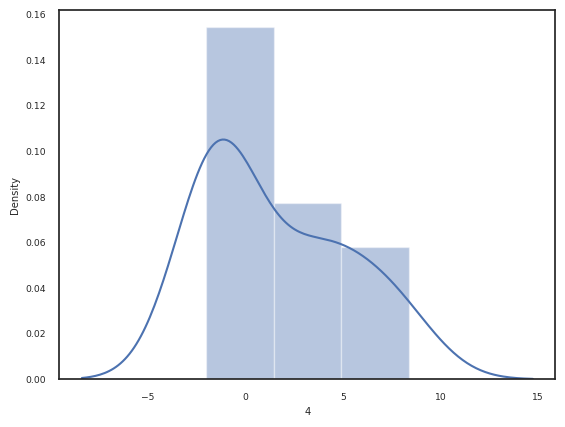

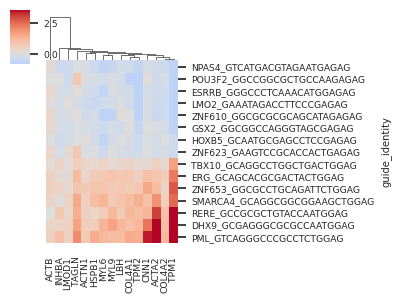

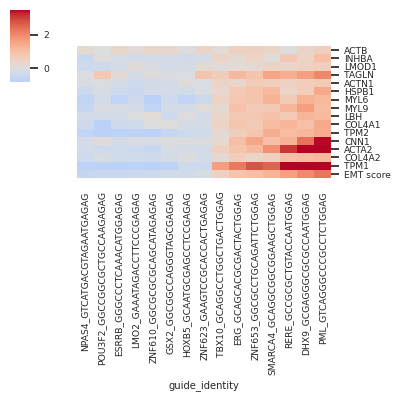

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'expression_program_name' is the name of the feature you are interested in
expression_program_name = 4  # Replace with the actual program name
guide_subset = np.union1d(low_EMT_guides, high_EMT_guides)
collapse_to_gene = False

# Step 1: Find the genes involved in the program
program_genes = comps.loc[expression_program_name]
program_gene_names = program_genes[program_genes > 0.05].sort_values(ascending=False).head(15).index.tolist()

# Step 2: Find the outlier columns for that expression program
feature_values = total_codes.loc[guide_subset, expression_program_name]
# outlier_threshold_high = feature_values.quantile(0.96)  # Adjust these thresholds as needed
# outlier_threshold_low = feature_values.quantile(0.01)
# outlier_perturbations = feature_values[(feature_values > outlier_threshold_high) | (feature_values < outlier_threshold_low)].index.tolist()
outlier_perturbations = guide_subset
outlier_perturbations = total_codes.loc[outlier_perturbations].sort_values(expression_program_name).index

sns.distplot(feature_values)

# Step 3: Extract gene expression data
# Replace 'gwps_mean_pop.where' with the actual method to extract the data from your dataset
expr = mean_pop.where(cells=outlier_perturbations, genes=program_gene_names)

# Step 4: Produce a clustermap of the gene expression data (without feature_values)
clustered = sns.clustermap(expr, cmap='coolwarm', center=0, method='average', metric='correlation', robust=True, row_cluster=False, figsize=[4,3])  # You can adjust the parameters as needed

# Step 5: Get the order of columns after clustering
reordered_column_indices = clustered.dendrogram_col.reordered_ind

# Step 6: Reorder expr dataframe according to the clustering
reordered_expr = expr.iloc[:, reordered_column_indices]

# Step 8: Add the mapped feature_values as the last column in the reordered expr dataframe
reordered_expr['EMT score'] = feature_values.div(feature_values.std())
if collapse_to_gene:
    reordered_expr.index = expr.index.map(lambda x: x.split('_')[0])
# reordered_expr now has the additional column 'feature_values' at the far right, maintaining the clustering order


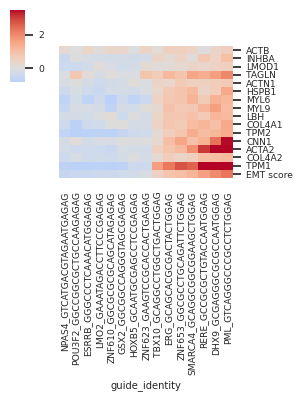

In [140]:
sns.set(font_scale=0.6)

clustered = sns.clustermap(reordered_expr.T, cmap='coolwarm', center=0, robust=True, row_cluster=False, col_cluster=False, figsize=[3,4])  # You can adjust the parameters as needed
clustered.savefig('20240409_seeds_EMT_score_example.pdf', bbox_inches='tight')